In [1]:
from imports_paper_plots import *
set_context_and_font()

In [2]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

from echoes import ESNRegressor
from echoes.plotting import plot_predicted_ts
from echoes.utils import relu

from bioRNN.tasks.memory.sequence import make_X_y
from bioRNN.utils import (
    make_r2_scorer,
    make_bioRRNs,
    cv_generator,
)

In [3]:
dir_res = Path(os.environ["DATAICNS"]) / "bioRNN"

In [4]:
task_name = "memory-sequence"
figs_path = Path(os.environ["DATAICNS"])/"bioRNN" /f"{task_name}/figs"

## Check ESN parameters for the task!

In [5]:
def plot_prediction_memory_sequence(*,y_test, y_pred, pattern_length, figs_path):
    start = pattern_length * 5
    end = (pattern_length * 5 * 3) + 1# 65, 150

    y_test_sub = y_test[start: end]
    y_pred_sub = y_pred[start: end]

    recall_timepoints, = np.where(y_test[start: end, 0] != 0)
    signals_timepoints, = np.where(X_test[start: end, 0])

    fig = plt.figure(figsize=(14, 5.4))

    plt.subplot(1, 3, (1, 2))
    plt.plot(y_test_sub, color=grey, linewidth=4, label="True")
    plt.plot(y_pred_sub, color=green, linewidth=3, label="Predicted",)
    plt.yticks([0, .5, 1], labels=[0, .5, 1])
    plt.xlabel("Time $(t)$")
    plt.ylabel(r"y$_{(t)}$")

    for i, timepoint in enumerate(signals_timepoints):
        if i == 0:
            plt.annotate("Recall signal", (timepoint-(pattern_length/3), 1.15), fontsize=17, color=orange)

        coords = (timepoint, 1.10, 0, -0.25,)
        plt.arrow(
            *coords, 
            length_includes_head=True,
            width=.4,
            alpha=.8,
            head_width=2,
            head_length=.1,
            ec=orange,
            fc=orange,
            lw=1.,
        )
    plt.ylim(-.35, 1.30)
    leg = plt.legend(loc="lower center", 
               ncol=2,
               fontsize=16,
               facecolor="1.",
               shadow=True,
               columnspacing=1,
               borderpad=.3,
               handletextpad=.4,
               handlelength=1.5,
               markerscale=1,
               handleheight=.001)

    plt.subplot(1, 3, 3)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.plot(y_test_sub[recall_timepoints],
             y_pred_sub[recall_timepoints],
             'o',
             markersize=9, 
             alpha=.85,
             color=orange,
             markerfacecolor=green,
             markeredgecolor="white",
             markeredgewidth=1.3,)
    plt.yticks([0, .5, 1], labels=[0, .5, 1])
    plt.xticks([0, .5, 1], labels=[0, .5, 1])
    plt.xlim((-0.08, 1.08))
    plt.ylim((-0.08, 1.08))

    # Plot identity
    plt.plot((0, 1), (0, 1), linewidth=3, color=grey, linestyle="--")

    axes = np.array(fig.axes)
    set_spines_width(axes, 2.5)
    remove_ticks(axes)

    #tweak_axes(np.array(fig.axes)) 
    for ax in axes:
        ax.grid(True, linestyle='--', alpha=.8, linewidth=1.5)

    plt.suptitle(fr"Pattern length ($L$) = {pattern_length}", fontsize=25, x=.5, y=.84)
    fig.tight_layout()#w_pad=0.5, )
    plt.savefig(figs_path/f"time-series_length-{pattern_length}.svg")

In [6]:
#    df = pd.DataFrame(grid.cv_results_)
#    df["pattern_length"] = pattern_length
#    df["W"] = df["param_W"]
#    df.drop(columns="param_W")
#    df = label_W_df(df, Ws_map)
#    results.append(df)

#results = pd.concat(results)
#results.head(2)

100%|██████████| 3/3 [00:10<00:00,  3.50s/it]


CPU times: user 3.88 s, sys: 1.66 s, total: 5.54 s
Wall time: 10.5 s


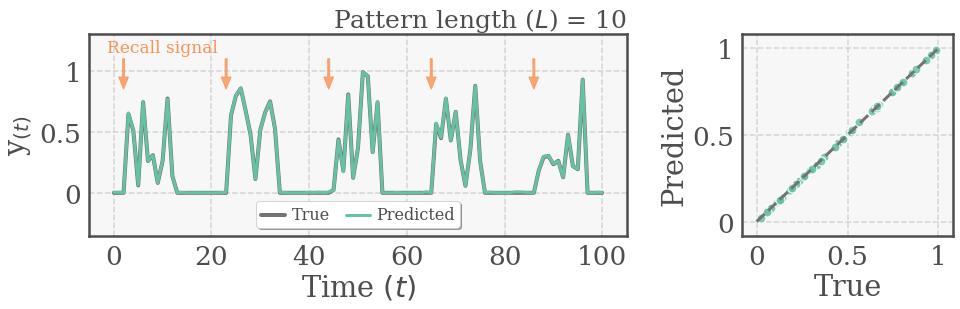

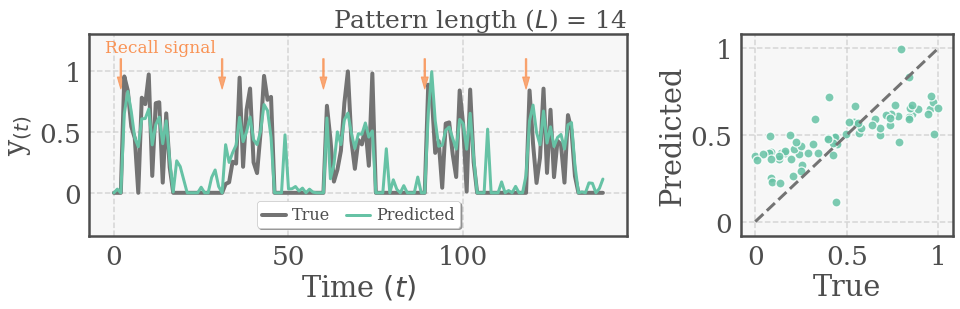

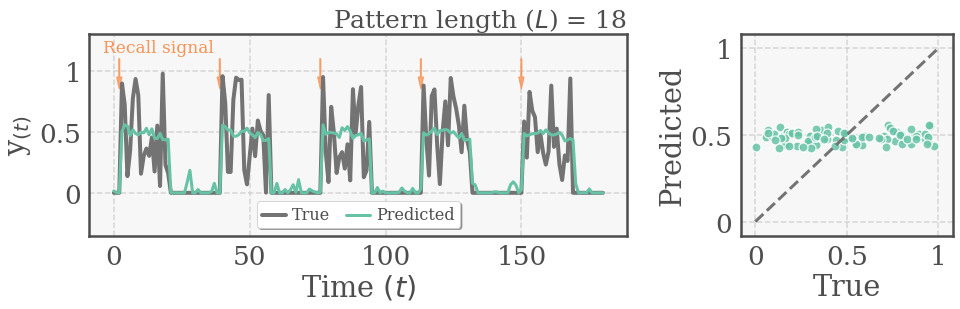

In [10]:
%%time

results = []
n_transient = 100 
lengths = [10, 14, 18]#range(5, 21)
for pattern_length in tqdm(lengths):
    task_params = dict(pattern_length=pattern_length, n_trials=1000)
    scorer = make_r2_scorer(n_transient=n_transient)
    X_train, y_train = make_X_y(**task_params)
    X_test, y_test = make_X_y(task_params["pattern_length"], n_trials=100)

    # Generate reservoirs based on connectomes
    Ws_map = make_bioRRNs(
        connectome_name="human", 
        neuron_density=1,
        rand_partition=True
    )

    param_grid = {
        "spectral_radius": [.99],
        "input_scaling": [1e-5],
        "W": [Ws_map["W_bio_norank"]],
        "bias": [1,],
        "activation_out": [relu],
    }

    cv = cv_generator(X_train, test_size=.2)
    grid = GridSearchCV(
        ESNRegressor(n_transient=n_transient, activation_out=relu),
        param_grid,
        scoring=scorer,
        verbose=0,
        cv=cv,
        refit="r2",
        n_jobs=-2
    ).fit(X_train, y_train)
    
    y_pred = grid.best_estimator_.predict(X_test)
    plot_prediction_memory_sequence(
        y_test=y_test,
        y_pred=y_pred,
        pattern_length=pattern_length,
        figs_path=figs_path
    )